<a href="https://colab.research.google.com/github/zeligism/ConGAN/blob/main/ConsistentGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Header

## Imports

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import glob
import random
import datetime
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torch.utils.tensorboard as tensorboard

from PIL import Image, ImageDraw
from math import log2
from pprint import pformat
from collections import defaultdict

## Utility Functions

### Report Utils

In [ ]:
def plot_lines(losses_dict, filename=None, title=""):
    """
    Plots the losses of the discriminator and the generator.

    Args:
        filename: The plot's filename. If None, plot won't be saved.
    """

    plt.figure(figsize=(10,5))
    plt.title(title)
    for label, losses in losses_dict.items():
        plt.plot(losses, label=label)
    plt.xlabel("t")
    plt.legend()
    
    if filename is not None:
        plt.savefig(filename)
    
    plt.show()
    plt.close()


def create_progress_animation(frames, filename):
    """
    Creates a video of the progress of the generator on a fixed latent vector.

    Args:
        filename: The animation's filename.
    """

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(img.permute(1,2,0), animated=True)]
           for img in frames]
    ani = animation.ArtistAnimation(fig, ims, blit=True)
    
    ani.save(filename)

    plt.close()


def generate_grid(generator, latent):
    """
    Check generator's output on latent vectors and return it.

    Args:
        generator: The generator.
        latent: Latent vector from which an image grid will be generated.

    Returns:
        A grid of images generated by `generator` from `latent`.
    """

    with torch.no_grad():
        fake = generator(latent).detach()

    image_grid = vutils.make_grid(fake.cpu(), padding=2, normalize=True, range=(-1,1))

    return image_grid



# Classes

## PyTorch Modules

### DCGAN

In [ ]:
class ConvBlock(nn.Module):
    """
    Default stride and padding half the size of features,
    e.g. if input is [in_channels, 64, 64], output will be [out_channels, 32, 32].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.conv = nn.utils.parametrizations.spectral_norm(self.conv)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.LeakyReLU(0.2, inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class ConvTBlock(nn.Module):
    """
    Default stride and padding double the size of features,
    e.g. if input is [in_channels, 32, 32], output will be [out_channels, 64, 64].
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 use_batchnorm=True, use_spectralnorm=False, activation=None):
        super().__init__()

        self.convT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                        stride=stride, padding=padding, bias=False)
        if use_spectralnorm:
            self.convT = nn.utils.parametrizations.spectral_norm(self.convT)
        self.batchnorm = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.activation = nn.ReLU(inplace=True) if activation is None else activation()

    def forward(self, x):
        x = self.convT(x)
        if self.batchnorm:
            x = self.batchnorm(x)
        x = self.activation(x)
        return x


class DCGAN_Discriminator(nn.Module):
    def __init__(self,
                 num_latents=16,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 output_sigmoid=True,
                 D_block=ConvBlock):
        super().__init__()

        using_grad_penalty = gan_type in ("gan-gp", "wgan-gp")
        output_sigmoid = output_sigmoid and gan_type in ("gan", "gan-gp")

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm and not using_grad_penalty,
            "use_spectralnorm": use_spectralnorm,
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Input layer
        self.input_layer = D_block(image_channels, features[0], **block_config)

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            D_block(in_features, out_features, **block_config)
            for in_features, out_features in zip(features, features[1:])
        ])

        # Output layer (feature_size = 3, 4, or 5 -> 1)
        if fully_convolutional:
            self.output_layer = nn.Sequential(
                nn.Conv2d(features[-1], num_latents, latent_kernel, bias=False),
                nn.Flatten(),
            )
        else:
            self.output_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(features[-1] * latent_kernel**2, num_latents, bias=False)
            )
        
        self.hidden_dim = features[-1] * latent_kernel**2

        # Add sigmoid activation if using regular GAN loss
        self.output_activation = nn.Sigmoid() if output_sigmoid else None

    def forward(self, x):
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        if self.output_activation:
            x = self.output_activation(x)
        # Remove H and W dimensions, infer channels dim (remove if 1)
        x = x.view(x.size(0), -1).squeeze(1)
        return x


class DCGAN_Generator(nn.Module):
    def __init__(self,
                 num_latents=100,
                 num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 max_features=512,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 G_block=ConvTBlock):
        super().__init__()

        block_config = {
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm
        }

        # Calculate intermediate image sizes
        image_sizes = [image_size]
        while image_sizes[-1] > 5:
            image_sizes.append(image_sizes[-1] // 2)
        latent_kernel = image_sizes[-1]  # should be either 3, 4, or 5
        num_layers = len(image_sizes) - 1

        # Calculate feature sizes
        features = [min(max_features, round(num_features * feature_multiplier**i))
                    for i in range(num_layers)]

        # Reverse order of image sizes and features for generator
        image_sizes = image_sizes[::-1]
        features = features[::-1]

        # Input layer
        if fully_convolutional:
            self.input_layer = G_block(num_latents, features[0], kernel_size=latent_kernel,
                                       stride=1, padding=0, **block_config)
        else:
            self.input_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_latents, features[0] * image_sizes[0]**2, bias=False),
                View(features[0], image_sizes[0], image_sizes[0])
            )

        # Intermediate layers
        self.main_layers = nn.Sequential(*[
            G_block(in_features, out_features, kernel_size=4+(expected_size%2), **block_config)
            for in_features, out_features, expected_size in zip(features, features[1:], image_sizes[1:])
        ])

        # Output layer
        self.output_layer = nn.ConvTranspose2d(features[-1], image_channels, kernel_size=4+(image_size%2),
                                               stride=2, padding=1, bias=False)
        self.output_activation = nn.Tanh()

    def forward(self, x):
        # Add H and W dimensions, infer channels dim (add if none)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.input_layer(x)
        x = self.main_layers(x)
        x = self.output_layer(x)
        x = self.output_activation(x)
        return x


class DCGAN(nn.Module):
    """Deep Convolutional Generative Adversarial Network"""

    def __init__(self,
                 num_latents=100,
                 D_num_features=64,
                 G_num_features=64,
                 image_channels=3,
                 image_size=64,
                 feature_multiplier=2,
                 gan_type="gan",
                 fully_convolutional=True,
                 activation=None,
                 use_batchnorm=True,
                 use_spectralnorm=False,
                 output_sigmoid=True,):
        """
        Initializes DCGAN.

        Args:
            num_latents: Number of latent factors.
            num_features: Number of features in the convolutions.
            image_channels: Number of channels in the input image.
            image_size: Size (i.e. height or width) of image.
            gan_type: Type of GAN (e.g. "gan" or "wgan-gp").
        """
        super().__init__()

        self.num_latents = num_latents
        self.D_num_features = D_num_features
        self.G_num_features = G_num_features
        self.image_channels = image_channels
        self.image_size = image_size
        self.feature_multiplier = feature_multiplier
        self.gan_type = gan_type
        self.fully_convolutional = fully_convolutional
        self.activation = activation
        self.use_batchnorm = use_batchnorm
        self.use_spectralnorm = use_spectralnorm

        D_params = {
            "num_latents": 1,  # XXX
            "num_features": D_num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": use_batchnorm,
            "use_spectralnorm": use_spectralnorm,
            "output_sigmoid": output_sigmoid,
        }
        G_params = {
            "num_latents": num_latents,
            "num_features": G_num_features,
            "image_channels": image_channels,
            "image_size": image_size,
            "feature_multiplier": feature_multiplier,
            "gan_type": gan_type,
            "fully_convolutional": fully_convolutional,
            "activation": activation,
            "use_batchnorm": True,
            "use_spectralnorm": False,  # XXX
        }

        self.D = DCGAN_Discriminator(**D_params)
        self.G = DCGAN_Generator(**G_params)


class View(nn.Module):
    def __init__(self, *shape, including_batch=False):
        super().__init__()
        self.shape = shape
        self.including_batch = including_batch
    
    def forward(self, x):
        if self.including_batch:
            return x.view(*self.shape)
        else:
            return x.view(x.size(0), *self.shape)

class ChannelNoise(nn.Module):
    """
    Channel noise injection module.
    Adds a linearly transformed noise to a convolution layer.
    """

    def __init__(self, num_channels, std=0.02):
        super().__init__()
        self.std = std
        self.scale = nn.Parameter(torch.ones(1, num_channels, 1, 1))


    def forward(self, x):
        noise_size = [x.size()[0], 1, *x.size()[2:]]  # single channel
        noise = self.std * torch.randn(noise_size).to(x)

        return x + self.scale * noise

### Third-party modules

#### DCGAN

In [ ]:
#https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/model.py

from torch.nn.utils.parametrizations import spectral_norm

class SNDCGAN_Generator(nn.Module):
    def __init__(self, z_dim, num_features=64, channels=3):
        super().__init__()
        self.z_dim = z_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 8*num_features, 4, stride=1),
            nn.BatchNorm2d(8*num_features),
            nn.ReLU(),
            nn.ConvTranspose2d(8*num_features, 4*num_features, 4, stride=2, padding=(1,1)),
            nn.BatchNorm2d(4*num_features),
            nn.ReLU(),
            nn.ConvTranspose2d(4*num_features, 2*num_features, 4, stride=2, padding=(1,1)),
            nn.BatchNorm2d(2*num_features),
            nn.ReLU(),
            nn.ConvTranspose2d(2*num_features, num_features, 4, stride=2, padding=(1,1)),
            nn.BatchNorm2d(num_features),
            nn.ReLU(),
            nn.ConvTranspose2d(num_features, channels, 3, stride=1, padding=(1,1)),
            # use this instead of last line for 64:
            # nn.ConvTranspose2d(64, 32, 4, stride=2, padding=(1,1)),
            nn.Tanh())

    def forward(self, z):
        return self.model(z.view(-1, self.z_dim, 1, 1))

class SNDCGAN_Discriminator(nn.Module):
    def __init__(self, num_features=64, channels=3):
        super().__init__()

        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(channels, num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(num_features, num_features, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(num_features, 2*num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(2*num_features, 2*num_features, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(2*num_features, 4*num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(4*num_features, 4*num_features, 4, stride=2, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            spectral_norm(nn.Conv2d(4*num_features, 8*num_features, 3, stride=1, padding=(1,1))),
            nn.LeakyReLU(0.1, inplace=True),
            # use this instead of last 2 lines for 64:
            # spectral_norm(nn.Conv2d(256, 256, 3, stride=1, padding=(1,1))),
            # nn.LeakyReLU(0.1, inplace=True),
            # spectral_norm(nn.Conv2d(256, 512, 3, stride=1, padding=(1,1))),
            # nn.LeakyReLU(0.1, inplace=True),
            nn.Flatten(),
        )

        self.hidden_dim = 4*4 * 8*num_features
        self.fc = spectral_norm(nn.Linear(self.hidden_dim, 1))

    def forward(self, x, return_h=False):
        h = self.main(x)
        out = self.fc(h).squeeze(1)
        if return_h:
            return out, h
        else:
            return out


class SNDCGAN(nn.Module):
    def __init__(self, num_latents, num_features=64, channels=3):
        super().__init__()
        self.num_latents = num_latents
        self.channels = channels
        self.D = SNDCGAN_Discriminator(channels=channels, num_features=num_features)
        self.G = SNDCGAN_Generator(num_latents, channels=channels, num_features=num_features)
    

#### ResNet GAN

In [ ]:
# https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/model_resnet.py

from torch.nn.utils import spectral_norm

class ResBlockGenerator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockGenerator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        nn.init.xavier_uniform_(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform_(self.conv2.weight.data, 1.)

        self.model = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            self.conv1,
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            self.conv2
            )
        self.bypass = nn.Sequential()
        if stride != 1:
            self.bypass = nn.Upsample(scale_factor=2)

    def forward(self, x):
        return self.model(x) + self.bypass(x)


class ResBlockDiscriminator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlockDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        nn.init.xavier_uniform_(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform_(self.conv2.weight.data, 1.)

        if stride == 1:
            self.model = nn.Sequential(
                nn.ReLU(),
                spectral_norm(self.conv1),
                nn.ReLU(),
                spectral_norm(self.conv2)
                )
        else:
            self.model = nn.Sequential(
                nn.ReLU(),
                spectral_norm(self.conv1),
                nn.ReLU(),
                spectral_norm(self.conv2),
                nn.AvgPool2d(2, stride=stride, padding=0)
                )
        self.bypass = nn.Sequential()
        if stride != 1:

            self.bypass_conv = nn.Conv2d(in_channels,out_channels, 1, 1, padding=0)
            nn.init.xavier_uniform_(self.bypass_conv.weight.data, np.sqrt(2))

            self.bypass = nn.Sequential(
                spectral_norm(self.bypass_conv),
                nn.AvgPool2d(2, stride=stride, padding=0)
            )
            # if in_channels == out_channels:
            #     self.bypass = nn.AvgPool2d(2, stride=stride, padding=0)
            # else:
            #     self.bypass = nn.Sequential(
            #         spectral_norm(nn.Conv2d(in_channels,out_channels, 1, 1, padding=0)),
            #         nn.AvgPool2d(2, stride=stride, padding=0)
            #     )


    def forward(self, x):
        return self.model(x) + self.bypass(x)

# special ResBlock just for the first layer of the discriminator
class FirstResBlockDiscriminator(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(FirstResBlockDiscriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)
        self.bypass_conv = nn.Conv2d(in_channels, out_channels, 1, 1, padding=0)
        nn.init.xavier_uniform_(self.conv1.weight.data, 1.)
        nn.init.xavier_uniform_(self.conv2.weight.data, 1.)
        nn.init.xavier_uniform_(self.bypass_conv.weight.data, np.sqrt(2))

        # we don't want to apply ReLU activation to raw image before convolution transformation.
        self.model = nn.Sequential(
            spectral_norm(self.conv1),
            nn.ReLU(),
            spectral_norm(self.conv2),
            nn.AvgPool2d(2)
            )
        self.bypass = nn.Sequential(
            nn.AvgPool2d(2),
            spectral_norm(self.bypass_conv),
        )

    def forward(self, x):
        return self.model(x) + self.bypass(x)

class SNResNet_Generator(nn.Module):
    def __init__(self, z_dim, image_size=64, channels=3):
        super().__init__()
        self.z_dim = z_dim
        self.image_size = image_size

        self.dense = nn.Linear(self.z_dim, 4 * 4 * image_size)
        self.final = nn.Conv2d(image_size, channels, 3, stride=1, padding=1)
        nn.init.xavier_uniform_(self.dense.weight.data, 1.)
        nn.init.xavier_uniform_(self.final.weight.data, 1.)

        self.model = nn.Sequential(
            ResBlockGenerator(image_size, image_size, stride=2),
            ResBlockGenerator(image_size, image_size, stride=2),
            ResBlockGenerator(image_size, image_size, stride=2),
            nn.BatchNorm2d(image_size),
            nn.ReLU(),
            self.final,
            nn.Tanh())

    def forward(self, z):
        return self.model(self.dense(z).view(-1, self.image_size, 4, 4))

class SNResNet_Discriminator(nn.Module):
    def __init__(self, image_size=64, channels=3):
        super().__init__()
        self.image_size = image_size

        self.model = nn.Sequential(
                FirstResBlockDiscriminator(channels, image_size, stride=2),
                ResBlockDiscriminator(image_size, image_size, stride=2),
                ResBlockDiscriminator(image_size, image_size),
                ResBlockDiscriminator(image_size, image_size),
                nn.ReLU(),
                nn.AvgPool2d(8),
            )
        self.fc = nn.Linear(image_size, 1)
        nn.init.xavier_uniform_(self.fc.weight.data, 1.)
        self.fc = spectral_norm(self.fc)

    def forward(self, x):
        return self.fc(self.model(x).view(-1, self.image_size))


class SNResNetGAN(nn.Module):
    def __init__(self, num_latents, image_size=64, channels=3):
        super().__init__()
        self.num_latents = num_latents
        self.channels = channels
        self.D = SNResNet_Discriminator(image_size=image_size, channels=channels)
        self.G = SNResNet_Generator(num_latents, image_size=image_size, channels=channels)


In [ ]:
! clone https://github.com/POSTECH-CVLab/PyTorch-StudioGAN.git


/bin/bash: clone: command not found


#### SimSiam

In [ ]:
class SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, base_encoder, dim=2048, pred_dim=512):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = base_encoder(num_classes=dim, zero_init_residual=True)

        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        # build a 2-layer predictor
        self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                        nn.BatchNorm1d(pred_dim),
                                        nn.ReLU(inplace=True), # hidden layer
                                        nn.Linear(pred_dim, dim)) # output layer

    def forward(self, x1, x2):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        # compute features for one view
        z1 = self.encoder(x1) # NxC
        z2 = self.encoder(x2) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        return p1, p2, z1.detach(), z2.detach()

### Latent Transform

In [ ]:
class LatentTransform(nn.Module):
    def __init__(self, repr_dim, latent_dim, hidden_dim, full_transform=True, noop=False):
        super().__init__()

        self.repr_dim = repr_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.full_transform = full_transform
        self.noop = noop

        if self.noop:
            self.output_dim = self.latent_dim
            return
        elif self.full_transform:
            self.input_dim = self.repr_dim + self.latent_dim
            self.output_dim = self.hidden_dim
        else:
            self.input_dim = self.repr_dim
            self.output_dim = self.hidden_dim + self.latent_dim

        self.transform = nn.Linear(self.input_dim, self.hidden_dim)
    
    def forward(self, repr, noise):
        if self.noop:
            return noise

        # assuming latent is concat as [repr,noise] XXX
        if self.full_transform:
            latent = torch.cat([repr, noise], dim=1)
            latent = self.transform(latent)
        else:
            repr = self.transform(repr)
            latent = torch.cat([repr, noise], dim=1)

        return latent


# Training v2

### Imports and globals

In [ ]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

GANSIAM_DIR = "/content/drive/My Drive/gansiam/"
SIMSIAM_PATH = os.path.join(GANSIAM_DIR, "pretrained_batch256.tar")
TINYIMAGENET_DIR = "tiny-imagenet-200"

### Download Tiny Imagenet

In [ ]:
%%bash
if [[ -d  "tiny-imagenet-200" ]]; then
    echo "Tiny Imagenet exists."
else
    wget -q "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    unzip -qq "tiny-imagenet-200.zip" && rm "tiny-imagenet-200.zip"
    echo "Downloaded Tiny Imagenet."
fi

Downloaded Tiny Imagenet.


### Load pre-trained SimSiam model


#### SimSiam Utils

In [ ]:
from PIL import ImageFilter
import random


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


In [ ]:
checkpoint = torch.load(SIMSIAM_PATH, map_location="cuda:0")
# remove 'module.' from dict keys
model_dict = OrderedDict((k[7:], v) for k, v in checkpoint["state_dict"].items())

# Load model
simsiam = SimSiam(models.__dict__["resnet50"])
simsiam.load_state_dict(model_dict)
#print(simsiam)

<All keys matched successfully>

# Training v3

## Args

In [ ]:
class Args:
    def __init__(self):
        self.load = False
        self.print_freq = 10
        self.seed = None
        self.gpu = 0
        self.workers = 2
        self.epochs = 100

        ### lr is about 2e-4 for batch size of 64
        # we scale according to our choice of batch size
        self.batch_size = 64
        self.D_lr = 2e-4 * (64 / self.batch_size)
        self.G_lr = 2e-4 * (64 / self.batch_size)
        self.Q_lr = self.D_lr
        self.latent_transform_lr = self.G_lr
        self.lr_decay = 0.02
        self.betas = (0.5, 0.999)

        # SimSiam (_don't change_ if loading pre-trained)
        self.dim = 2048
        self.pred_dim = 512

        # GAN
        self.repr_dim = self.dim  # don't change
        self.latent_full_transform = True
        self.latent_noise_dim = 128
        self.latent_hidden_dim = 128*2  # dim of transform output
        self.num_features = 64
        self.D_iters = 5

        self.gan_type = "gan"  # ignore this
        self.wgan = False  # if False, use spectral norm
        self.grad_penalty = 0.  # 0 if wgan is False
        self.grad_center = 1.  # not important

        self.generate_grid_interval = 200

        # make noise proportional to sd(data)
        self.im_noise = 1e-3  # image sd is about 1.0
        self.repr_noise = 1e-6  # (normalized) repr sd is about 0.001


        self.G_consistency = 0.1
        self.D_consistency = 0.1


GENERATED_GRIDS = []
IMAGE_SIZE = 32
DATASET = "CIFAR10"
args = Args()

## Data

In [ ]:
# image normalization
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]
mean = [0.5]
std = [0.5]
normalize = transforms.Normalize(mean=mean, std=std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

augmentation = [
    #transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
_augmentation = [
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

if DATASET == "MNIST":
    augmentation = [transforms.Grayscale(3)] + augmentation
    train_dataset = datasets.MNIST(
        root=os.path.join(GANSIAM_DIR, "mnist/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CelebA":
    train_dataset = datasets.CelebA(
        root=os.path.join(GANSIAM_DIR, "celeba"), download=True,
        transform=transforms.Compose(augmentation))
elif DATASET == "CIFAR10":
    train_dataset = datasets.CIFAR10(
        root=os.path.join(GANSIAM_DIR, "cifar10/train"), train=True, download=True,
        transform=transforms.Compose(augmentation))
        #transform=TwoCropsTransform(transforms.Compose(augmentation)))
elif DATASET == "Tiny Imagenet":
    train_dataset = datasets.ImageFolder(
        root=os.path.join(TINYIMAGENET_DIR, 'train'),
        transform=transforms.Compose(augmentation))
else:
    raise Exception(f"Dataset '{DATASET}' not found")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True, sampler=None, drop_last=True)

Files already downloaded and verified


### Losses

In [ ]:
def D_criterion_NS(D_real, D_fake):
    d_loss = F.softplus(-D_real) + F.softplus(D_fake)
    return d_loss.mean()

def G_criterion_NS(D_fake):
    return F.softplus(-D_fake).mean()

def D_criterion_LS(D_real, D_fake):
    d_loss = 0.5 * (D_real - torch.ones_like(D_real))**2 + 0.5 * (D_fake)**2
    return d_loss.mean()

def G_criterion_LS(D_fake):
    gen_loss = 0.5 * (D_fake - torch.ones_like(D_fake))**2
    return gen_loss.mean()

def D_criterion_hinge(D_real, D_fake):
    return torch.mean(F.relu(1. - D_real)) + torch.mean(F.relu(1. + D_fake))

def G_criterion_hinge(D_fake):
    return -torch.mean(D_fake)

def D_criterion_wasserstein(D_real, D_fake):
    return torch.mean(D_fake - D_real)

def G_criterion_wasserstein(D_fake):
    return -torch.mean(D_fake)

def interpolate(real, fake):
    eps_size = [1] * len(real.size())
    eps_size[0] = real.size(0)
    eps = torch.rand(eps_size).to(real)
    return eps * real + (1 - eps) * fake

def simple_gradient_penalty(D, x, center=0.):
    x.requires_grad_()
    D_x = D(x)
    D_grad = torch.autograd.grad(D_x, x, torch.ones_like(D_x), create_graph=True)
    D_grad_norm = D_grad[0].view(x.size(0), -1).norm(dim=1)
    return (D_grad_norm - center).pow(2).mean()


## Model + Opt

In [ ]:
if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True

torch.cuda.set_device(args.gpu)

latent_transform = LatentTransform(repr_dim=args.repr_dim,
                                   latent_dim=args.latent_noise_dim,
                                   hidden_dim=args.latent_hidden_dim,
                                   full_transform=args.latent_full_transform,
                                   #noop=True,  # for testing
                                   )


model = DCGAN(num_latents=latent_transform.output_dim,
              image_size=IMAGE_SIZE,
              gan_type=args.gan_type,  # doesn't make a difference
              num_features=args.num_features,
              use_batchnorm=False,  # for D only
              output_sigmoid=False,  # for D only
              use_spectralnorm=not args.wgan,  # for spectral norm, use the below model
              )

if not args.wgan:
    model = SNDCGAN(num_latents=latent_transform.output_dim,
                    num_features=args.num_features)

#Q = nn.Linear(model.D.hidden_dim, args.repr_dim)
Q_hidden_dim = 128
Q = nn.Sequential(nn.Linear(model.D.hidden_dim, Q_hidden_dim, bias=False),
                  nn.BatchNorm1d(Q_hidden_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(Q_hidden_dim, args.repr_dim))
if args.D_consistency == 0.:
    Q = nn.Module()

model = model.cuda(args.gpu)
Q = Q.cuda(args.gpu)
latent_transform = latent_transform.cuda(args.gpu)
simsiam = simsiam.cuda(args.gpu)

print("Num of params in D:", sum(map(torch.numel, model.D.parameters())))
print("Num of params in G:", sum(map(torch.numel, model.G.parameters())))
print("Num of params in Q:", sum(map(torch.numel, Q.parameters())))
print("Num of params in L:", sum(map(torch.numel, latent_transform.parameters())))

# Define D and G loss functions
if args.wgan:
    args.grad_penalty = 10.
    D_criterion = D_criterion_wasserstein
    G_criterion = G_criterion_wasserstein
else:
    args.grad_penalty = 0.
    D_criterion = D_criterion_LS
    G_criterion = G_criterion_LS

# Optimizers
D_optimizer = torch.optim.Adam(model.D.parameters(), args.D_lr, betas=args.betas)
G_optimizer = torch.optim.Adam(
    [{"params": model.G.parameters()},
     {"params": latent_transform.parameters(), "lr": args.latent_transform_lr}],
     args.G_lr, betas=args.betas)
Q_optimizer = torch.optim.Adam(Q.parameters(), args.Q_lr, betas=args.betas)

D_sched = torch.optim.lr_scheduler.ExponentialLR(D_optimizer, 1. - args.lr_decay)
G_sched = torch.optim.lr_scheduler.ExponentialLR(G_optimizer, 1. - args.lr_decay)
Q_sched = torch.optim.lr_scheduler.ExponentialLR(Q_optimizer, 1. - args.lr_decay)

cudnn.benchmark = True

if args.load:
    model.load_state_dict(torch.load(f"{GANSIAM_DIR}/results/model.pth.tar"))
    latent_transform.load_state_dict(torch.load(f"{GANSIAM_DIR}/results/latent_transform.pth.tar"))
    D_sched.load_state_dict(torch.load(f"{GANSIAM_DIR}/results/D_sched.pth.tar"))
    G_sched.load_state_dict(torch.load(f"{GANSIAM_DIR}/results/G_sched.pth.tar"))

Num of params in D: 2935873
Num of params in G: 4854275
Num of params in Q: 1313024
Num of params in L: 557312


In [ ]:
print(model)
print(Q)
print(latent_transform)

SNDCGAN(
  (D): SNDCGAN_Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.1, inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
      (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.1, inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): LeakyReLU(negative_slope=0.1, inplace=True)
      (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): LeakyReLU(negative_slope=0.1, inplace=True)
 

## Train

In [ ]:
def sample_latent(num_samples):
    return torch.randn(num_samples, args.latent_noise_dim)

def check_G_progress(G):
    with torch.no_grad():
        z = latent_transform(fixed_repr, fixed_noise)
        fake_progress = G(z)
    im_grid = torch.cat([fixed_x, fake_progress], dim=0)
    grid = vutils.make_grid(im_grid.cpu(), padding=2, normalize=True, range=(-1,1))
    return grid

In [ ]:
# Sample a global latent for reuse
fixed_x, _ = next(iter(train_loader))
fixed_x = fixed_x[:32].cuda(args.gpu)
with torch.no_grad():
    fixed_repr = simsiam.encoder(fixed_x)
    fixed_repr = F.normalize(fixed_repr)
fixed_noise = sample_latent(32).cuda(args.gpu)
fixed_latent = torch.cat([fixed_repr, fixed_noise], dim=1)

In [ ]:
def train(train_loader, model, simsiam,
          D_criterion, G_criterion, D_optimizer, G_optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    D_on_reals = AverageMeter('D(real)', ':.4f')
    D_on_fakes1 = AverageMeter('D(fake)1', ':.4f')
    D_on_fakes2 = AverageMeter('D(fake)2', ':.4f')
    D_grads = AverageMeter('grad(D)', ':.4f')
    G_repr_losses = AverageMeter('G repr loss', ':.4f')
    D_repr_losses = AverageMeter('G repr loss', ':.4f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time,
         D_on_reals, D_on_fakes1, D_on_fakes2, D_grads, G_repr_losses, D_repr_losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()
    D_grad_penalty = torch.zeros(1).cuda(args.gpu)
    repr_loss = torch.zeros(1).cuda(args.gpu)

    end = time.time()
    for i, (x, y) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        x = x.cuda(args.gpu, non_blocking=True)
        batch_size = x.size(0)

        # compute output and loss
        with torch.no_grad():
            repr = simsiam.encoder(x)
            repr = F.normalize(repr + args.repr_noise * torch.randn_like(repr))

        ### train GAN
        # Add noise to real sample
        real = x + args.im_noise * torch.randn_like(x)

        # Sample from generator
        with torch.no_grad():
            noise = sample_latent(batch_size).cuda(args.gpu)
            z = latent_transform(repr, noise)
            fake = model.G(z)
            # Add noise to fake sample as well
            fake = fake + args.im_noise * torch.randn_like(fake)

        # Classify real and fake data
        D_real = model.D(real)
        D_fake = model.D(fake)

        # Calculate loss
        D_loss = D_criterion(D_real, D_fake)
        # Gradient penalty
        if args.grad_penalty != 0.:
            D_grad_penalty = simple_gradient_penalty(
                model.D, interpolate(real, fake), center=args.grad_center)
            D_loss += args.grad_penalty * D_grad_penalty

        # Calculate gradient and minimize
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Save data
        D_on_reals.update(D_real.mean().item(), batch_size)
        D_on_fakes1.update(D_fake.mean().item(), batch_size)
        D_grads.update(D_grad_penalty.mean().item(), batch_size)

        if (i+1) % args.D_iters == 0:
            # Sample from generator
            noise = sample_latent(batch_size).cuda(args.gpu)
            z = latent_transform(repr, noise)
            fake = model.G(z)
            fake = fake + args.im_noise * torch.randn_like(fake)
            # Classify fake images
            D_fake = model.D(fake)
            # Calculate adversarial loss
            G_loss = G_criterion(D_fake)
            # Caluclate consistency loss
            if args.G_consistency != 0.:
                G_repr = simsiam.encoder(fake)
                G_repr_loss = -F.cosine_similarity(G_repr, repr).mean()
            # Calculate gradient and minimize
            G_optimizer.zero_grad()
            (G_loss + args.G_consistency * G_repr_loss).backward()
            G_optimizer.step()

            # InfoGAN training
            if args.D_consistency != 0.:
                # Sample from generator
                noise = sample_latent(batch_size).cuda(args.gpu)
                z = latent_transform(repr, noise)
                fake = model.G(z)
                fake = fake + args.im_noise * torch.randn_like(fake)
                # Classify fake and find similarity
                D_fake, h_fake = model.D(fake, return_h=True)
                D_repr = Q(h_fake)
                D_repr_loss = -F.cosine_similarity(D_repr, repr).mean()
                # Train whole GAN
                D_optimizer.zero_grad()
                G_optimizer.zero_grad()
                Q_optimizer.zero_grad()
                (args.D_consistency * D_repr_loss).backward()
                D_optimizer.step()
                G_optimizer.step()
                Q_optimizer.step()

            # Save data
            D_on_fakes2.update(D_fake.mean().item(), batch_size)
            G_repr_losses.update(G_repr_loss.mean().item(), batch_size)
            D_repr_losses.update(D_repr_loss.mean().item(), batch_size)

        # Check generator's progress by recording its output on a fixed input
        if i % args.generate_grid_interval == 0:
            grid = check_G_progress(model.G)
            GENERATED_GRIDS.append(grid)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)


## Run

In [ ]:
def save():
    torch.save({'state_dict': model.state_dict()},
                f"{GANSIAM_DIR}/results/model.pth.tar")
    torch.save({'state_dict': latent_transform.state_dict()},
                f"{GANSIAM_DIR}/results/latent_transform.pth.tar")
    torch.save({'state_dict': D_sched.state_dict()},
                f"{GANSIAM_DIR}/results/D_sched.pth.tar")
    torch.save({'state_dict': G_sched.state_dict()},
                f"{GANSIAM_DIR}/results/G_sched.pth.tar")

def save_vid():
    vidname = f"grids_per_{args.generate_grid_interval}_iters.mp4"
    vidname = os.path.join(GANSIAM_DIR, "results", "progress", vidname)
    create_progress_animation(GENERATED_GRIDS, vidname)

def run(epochs):
    for epoch in range(epochs):

        # train for one epoch
        train(train_loader, model, simsiam,
            D_criterion, G_criterion, D_optimizer, G_optimizer, epoch, args)

        D_sched.step()
        G_sched.step()

        # Check G's progress evey epoch by generating an image
        grid = check_G_progress(model.G)
        imname = f'{GANSIAM_DIR}/results/progress/grid_{epoch:04d}.png'
        plt.imsave(imname, grid.permute(1,2,0).numpy())

        if epoch % 10 == 0:
            save()


In [ ]:
run(10)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/781]	Time  1.357 ( 1.357)	Data  0.093 ( 0.093)	D(real) 0.0233 (0.0233)	D(fake)1 0.0190 (0.0190)	D(fake)2 0.2389 (0.2389)	grad(D) 0.0000 (0.0000)	G repr loss -0.0466 (-0.0466)	G repr loss 0.0040 (0.0040)
Epoch: [0][ 10/781]	Time  0.201 ( 0.319)	Data  0.000 ( 0.009)	D(real) 0.8263 (0.3257)	D(fake)1 0.4846 (0.2815)	D(fake)2 0.2424 (0.2613)	grad(D) 0.0000 (0.0000)	G repr loss -0.0343 (-0.0789)	G repr loss -0.0387 (-0.0109)
Epoch: [0][ 20/781]	Time  0.206 ( 0.267)	Data  0.000 ( 0.005)	D(real) 0.2331 (0.3574)	D(fake)1 0.1551 (0.2115)	D(fake)2 0.1517 (0.1963)	grad(D) 0.0000 (0.0000)	G repr loss -0.6866 (-0.2254)	G repr loss -0.1153 (-0.0303)
Epoch: [0][ 30/781]	Time  0.203 ( 0.249)	Data  0.000 ( 0.003)	D(real) 0.3582 (0.4051)	D(fake)1 0.0914 (0.1940)	D(fake)2 0.1013 (0.1701)	grad(D) 0.0000 (0.0000)	G repr loss -0.5601 (-0.3689)	G repr loss -0.3557 (-0.1060)
Epoch: [0][ 40/781]	Time  0.203 ( 0.238)	Data  0.000 ( 0.002)	D(real) 0.7779 (0.4771)	D(fake)1 -0.3251 (0.1539)	D(fake)2 0

In [ ]:
run(10)
save_vid()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/781]	Time  0.326 ( 0.326)	Data  0.095 ( 0.095)	D(real) 0.7300 (0.7300)	D(fake)1 0.0065 (0.0065)	D(fake)2 0.1348 (0.1348)	grad(D) 0.0000 (0.0000)	G repr loss -0.6146 (-0.6146)	G repr loss -0.8096 (-0.8096)
Epoch: [0][ 10/781]	Time  0.210 ( 0.221)	Data  0.000 ( 0.009)	D(real) 0.8626 (0.8158)	D(fake)1 0.1113 (0.1664)	D(fake)2 0.2008 (0.1920)	grad(D) 0.0000 (0.0000)	G repr loss -0.6252 (-0.5914)	G repr loss -0.9395 (-0.8468)
Epoch: [0][ 20/781]	Time  0.204 ( 0.215)	Data  0.000 ( 0.005)	D(real) 0.8006 (0.8132)	D(fake)1 0.1779 (0.1784)	D(fake)2 0.2206 (0.1880)	grad(D) 0.0000 (0.0000)	G repr loss -0.7223 (-0.6336)	G repr loss -0.9341 (-0.8536)
Epoch: [0][ 30/781]	Time  0.209 ( 0.212)	Data  0.000 ( 0.003)	D(real) 0.9642 (0.8232)	D(fake)1 0.5198 (0.1821)	D(fake)2 -0.0241 (0.1821)	grad(D) 0.0000 (0.0000)	G repr loss -0.7926 (-0.6791)	G repr loss -0.9336 (-0.8716)
Epoch: [0][ 40/781]	Time  0.210 ( 0.210)	Data  0.000 ( 0.003)	D(real) 0.8127 (0.8218)	D(fake)1 0.1420 (0.1694)	D(fake)2

In [ ]:
run(10)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/781]	Time  0.327 ( 0.327)	Data  0.083 ( 0.083)	D(real) 0.8786 (0.8786)	D(fake)1 0.0858 (0.0858)	D(fake)2 0.2163 (0.2163)	grad(D) 0.0000 (0.0000)	G repr loss -0.7448 (-0.7448)	G repr loss -0.8962 (-0.8962)
Epoch: [0][ 10/781]	Time  0.212 ( 0.222)	Data  0.000 ( 0.008)	D(real) 0.7530 (0.8523)	D(fake)1 0.0680 (0.1422)	D(fake)2 0.2338 (0.1792)	grad(D) 0.0000 (0.0000)	G repr loss -0.7041 (-0.6898)	G repr loss -0.9065 (-0.9065)
Epoch: [0][ 20/781]	Time  0.203 ( 0.220)	Data  0.000 ( 0.004)	D(real) 0.8240 (0.8322)	D(fake)1 0.2461 (0.1569)	D(fake)2 0.1963 (0.1703)	grad(D) 0.0000 (0.0000)	G repr loss -0.8011 (-0.6846)	G repr loss -0.9617 (-0.9144)
Epoch: [0][ 30/781]	Time  0.205 ( 0.216)	Data  0.000 ( 0.003)	D(real) 0.9400 (0.8374)	D(fake)1 0.3741 (0.1613)	D(fake)2 0.0495 (0.1691)	grad(D) 0.0000 (0.0000)	G repr loss -0.6751 (-0.6945)	G repr loss -0.9300 (-0.9132)
Epoch: [0][ 40/781]	Time  0.200 ( 0.214)	Data  0.000 ( 0.002)	D(real) 0.7341 (0.8358)	D(fake)1 -0.0804 (0.1506)	D(fake)2

In [ ]:
run(10)
save_vid()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/781]	Time  0.336 ( 0.336)	Data  0.093 ( 0.093)	D(real) 0.7863 (0.7863)	D(fake)1 0.0861 (0.0861)	D(fake)2 0.2554 (0.2554)	grad(D) 0.0000 (0.0000)	G repr loss -0.7192 (-0.7192)	G repr loss -0.9397 (-0.9397)
Epoch: [0][ 10/781]	Time  0.210 ( 0.219)	Data  0.000 ( 0.009)	D(real) 0.8952 (0.8094)	D(fake)1 0.2513 (0.1802)	D(fake)2 0.1637 (0.1703)	grad(D) 0.0000 (0.0000)	G repr loss -0.6735 (-0.6472)	G repr loss -0.9196 (-0.9241)
Epoch: [0][ 20/781]	Time  0.206 ( 0.212)	Data  0.000 ( 0.005)	D(real) 0.9249 (0.8183)	D(fake)1 0.2771 (0.1859)	D(fake)2 0.0957 (0.1849)	grad(D) 0.0000 (0.0000)	G repr loss -0.6925 (-0.6517)	G repr loss -0.9677 (-0.9117)
Epoch: [0][ 30/781]	Time  0.204 ( 0.211)	Data  0.000 ( 0.003)	D(real) 0.8364 (0.8238)	D(fake)1 0.1204 (0.1766)	D(fake)2 0.1669 (0.1781)	grad(D) 0.0000 (0.0000)	G repr loss -0.6788 (-0.6415)	G repr loss -0.9709 (-0.8935)
Epoch: [0][ 40/781]	Time  0.209 ( 0.211)	Data  0.000 ( 0.002)	D(real) 0.9287 (0.8236)	D(fake)1 0.1920 (0.1771)	D(fake)2 

In [ ]:
run(10)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


Epoch: [0][  0/781]	Time  0.357 ( 0.357)	Data  0.098 ( 0.098)	D(real) 0.8310 (0.8310)	D(fake)1 0.0991 (0.0991)	D(fake)2 0.1818 (0.1818)	grad(D) 0.0000 (0.0000)	G repr loss -0.7044 (-0.7044)	G repr loss -0.8848 (-0.8848)
Epoch: [0][ 10/781]	Time  0.204 ( 0.224)	Data  0.000 ( 0.009)	D(real) 0.8485 (0.8244)	D(fake)1 0.3045 (0.1935)	D(fake)2 0.0607 (0.1529)	grad(D) 0.0000 (0.0000)	G repr loss -0.2595 (-0.6661)	G repr loss -0.5287 (-0.8976)
Epoch: [0][ 20/781]	Time  0.201 ( 0.216)	Data  0.000 ( 0.005)	D(real) 0.7899 (0.8264)	D(fake)1 0.2211 (0.1798)	D(fake)2 0.1740 (0.1549)	grad(D) 0.0000 (0.0000)	G repr loss -0.8134 (-0.6859)	G repr loss -0.9762 (-0.9196)
Epoch: [0][ 30/781]	Time  0.208 ( 0.213)	Data  0.000 ( 0.003)	D(real) 0.8303 (0.8297)	D(fake)1 0.1853 (0.1707)	D(fake)2 0.1189 (0.1541)	grad(D) 0.0000 (0.0000)	G repr loss -0.6929 (-0.6639)	G repr loss -0.9646 (-0.9109)
Epoch: [0][ 40/781]	Time  0.215 ( 0.212)	Data  0.000 ( 0.003)	D(real) 0.9084 (0.8337)	D(fake)1 0.3618 (0.1697)	D(fake)2 

KeyboardInterrupt: ignored

In [ ]:
run(10)
save_vid()

In [ ]:
run(10)
save_vid()
save()

In [ ]:
run(10)
save_vid()
save()

In [ ]:
run(10)
save_vid()
save()

In [ ]:
run(15)

In [ ]:
run(15)
save_vid()

In [ ]:
run(10)
save_vid()

## Results

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


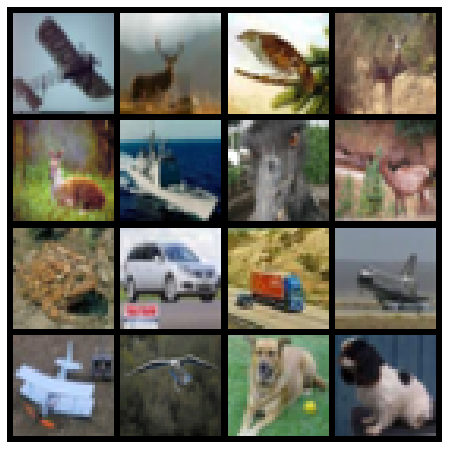

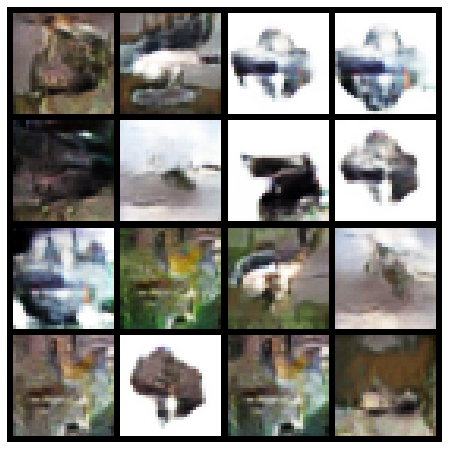

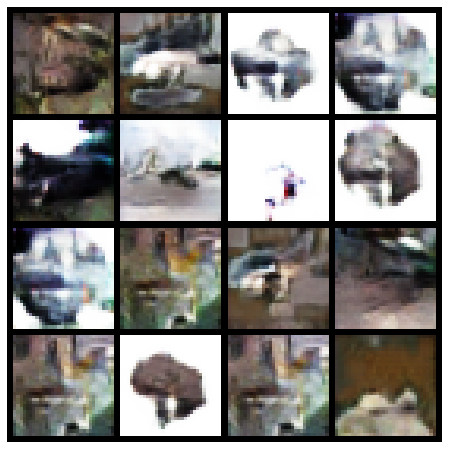

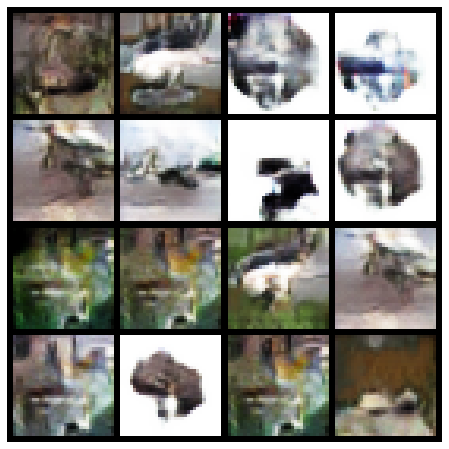

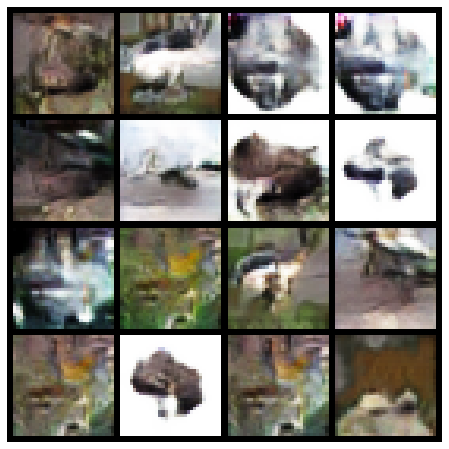

In [ ]:
%matplotlib inline

def show_sample(x, num_samples=16, show_x=False):
    x = x.cuda(args.gpu)[:num_samples]
    if show_x:
        x_grid = vutils.make_grid(inv_normalize(x).cpu(), padding=2, nrow=4)
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.imshow(x_grid.permute(1,2,0))

    model.eval()
    with torch.no_grad():
        noise = sample_latent(num_samples).cuda(args.gpu)
        repr = simsiam.encoder(x)
        repr = F.normalize(repr + args.repr_noise * torch.randn_like(repr))
        z = latent_transform(repr, noise)
        x_fake = model.G(z)
    im_grid = vutils.make_grid(x_fake.cpu(), padding=2, nrow=4, normalize=True, range=(-1,1))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(im_grid.permute(1,2,0))

x, _ = next(iter(train_loader))
show_sample(x, show_x=True)
show_sample(x)
show_sample(x)
show_sample(x)

In [ ]:
save_vid()
save()